In [1]:
import matplotlib.pyplot as plt
import numpy as np

from hazma.scalar_mediator import ScalarMediator
from hazma.vector_mediator import VectorMediator
from hazma.parameters import neutral_pion_mass as mpi0
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import (energy_res_e_astrogam,
                                                               A_eff_e_astrogam,
                                                               A_eff_comptel,
                                                               egret_diffuse,
                                                               fermi_diffuse,
                                                               comptel_diffuse,
                                                               gc_bg_model_target,
                                                               gc_bg_model)
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum

colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

## Load relic density curve

In [2]:
rd_mxs, rd_lims = np.loadtxt("relic_abundance.dat", delimiter=",").T
rd_mxs = 1e3*10.**rd_mxs  # convert GeV -> MeV
rd_lims = 10.**rd_lims

# Scalar mediator

## Setup

In [3]:
s_theta = 0.5
sm_hp = ScalarMediator(mx=1., ms=1000., gsxx=1.0, gsff=s_theta, gsGG=s_theta, gsFF=-s_theta)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 3  # 100
sm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

In [4]:
import time

t_i = time.time()

sm_lims_e_astrogam = sm_hp.unbinned_limits(sm_mxs, target_params=gc_bg_model_target, bg_model=gc_bg_model, A_eff=A_eff_e_astrogam)

t_f = time.time()
print("%f seconds" % (t_f - t_i))

('I_S error:', 3.1317860888837024e-06)
('I_B error:', 0.00010155012645667548)
('I_S error:', 1.5174194686846479e-05)
('I_B error:', 0.0001480804643673645)
('I_S error:', 1.637840060090125e-05)
('I_B error:', 0.001042143350489294)
('I_S error:', 0.00023649184897570248)
('I_B error:', 0.0008326257937138686)
('I_S error:', 0.000722229391547487)
('I_B error:', 0.004401077320632413)
('I_S error:', 0.0005333429705789206)
('I_B error:', 0.009107418415804888)
('I_S error:', 6.670726428561758e-05)
('I_B error:', 0.004242594532432006)
('I_S error:', 1.5627791018043148e-11)
('I_B error:', 5.32363227646462e-11)
('I_S error:', 1.0711351217084571e-05)
('I_B error:', 0.006732703988844525)
('I_S error:', 2.2948291354333418e-11)
('I_B error:', 7.688050294266371e-11)
('I_S error:', 7.085654320407462e-05)
('I_B error:', 0.003015907336473218)
('I_S error:', 1.8590683706758858e-11)
('I_B error:', 6.203118309731464e-11)
('I_S error:', 6.468500225112945e-05)
('I_B error:', 0.0036763602158519583)
('I_S error:

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:102: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = A_eff(e_a)/np.sqrt(I_B_val) * (dnde(e_a) -
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:105: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -A_eff(e_b)/np.sqrt(I_B_val) * (dnde(e_b) -
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:110: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/scalar_mediator/scalar_mediator_spectra.py:80: RuntimeWarning: invalid value encountered in sqrt
  return 2. * dnde_decay_s(egams, eng_s, ms, pw_array, mode)


('I_S error:', 8.827561945465914e-06)
('I_B error:', 0.00010155012645667548)
('I_S error:', 2.6735364672430024e-05)
('I_B error:', 8.632301311514128e-05)
('I_S error:', 9.423782781019299e-05)
('I_B error:', 0.0006321156171642822)
('I_S error:', 0.0032107090708476645)
('I_B error:', 0.004884966147853988)
('I_S error:', 6.251750021595007)
('I_B error:', 46.076189188089494)
('I_S error:', 0.003230277427446457)
('I_B error:', 0.761869034991153)
('I_S error:', 0.0004624340859051056)
('I_B error:', 0.813941072371658)
('I_S error:', 4.4707075099906265e-06)
('I_B error:', 0.9708187441433364)
('I_S error:', 0.00046532563826746166)
('I_B error:', 0.6361954656015572)
('I_S error:', 0.001798022174021932)
('I_B error:', 1.2010663222294822)
('I_S error:', 0.0010801781475239258)
('I_B error:', 0.5085751098174415)
('I_S error:', 0.0014191927323040038)
('I_B error:', 0.5529308394442929)
('I_S error:', 0.02367501408443117)
('I_B error:', 0.7785018608322295)
('I_S error:', 0.4078403411068193)
('I_B error

In [5]:
sm_lims_e_astrogam

array([2.42996394e-29, 7.10807527e-30, 2.07499860e-29])

In [10]:
import time

t_i = time.time()

sm_lims_egret = sm_hp.binned_limits(sm_mxs, egret_diffuse)
sm_lims_comptel = sm_hp.binned_limits(sm_mxs, comptel_diffuse)
sm_lims_fermi = sm_hp.binned_limits(sm_mxs, fermi_diffuse)

t_f = time.time()
print("%f seconds" % (t_f - t_i))

98.944903 seconds


In [18]:
sm_lims_cmb = sm_hp.cmb_limits(sm_mxs)

In [27]:
sm_lims_cmb_alternate = sm_hp.cmb_limits(sm_mxs, x_kd=1.0e-6)

### Save results

In [20]:
# np.savetxt("data/sm_lims_egret.csv",
#            np.array([sm_mxs, sm_lims_egret]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/sm_lims_comptel.csv",
#            np.array([sm_mxs, sm_lims_comptel]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/sm_lims_fermi.csv",
#            np.array([sm_mxs, sm_lims_fermi]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

# np.savetxt("data/sm_lims_e_astrogam.csv",
#            np.array([sm_mxs, sm_lims_e_astrogam]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

# np.savetxt("data/sm_lims_cmb.csv",
#            np.array([sm_mxs, sm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/sm_lims_cmb_alternate.csv",
#            np.array([sm_mxs, sm_lims_cmb_alternate]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

## Load previously computed constraints

In [6]:
# sm_mxs, sm_lims_egret = np.loadtxt("data/sm_lims_egret.csv", delimiter=",").T
# sm_mxs, sm_lims_comptel = np.loadtxt("data/sm_lims_comptel.csv", delimiter=",").T
# sm_mxs, sm_lims_fermi = np.loadtxt("data/sm_lims_fermi.csv", delimiter=",").T
# sm_mxs, sm_lims_e_astrogam = np.loadtxt("data/sm_lims_e_astrogam.csv", delimiter=",").T
sm_mxs, sm_lims_cmb = np.loadtxt("data/sm_lims_cmb.csv", delimiter=",").T
sm_mxs, sm_lims_cmb_alternate = np.loadtxt("data/sm_lims_cmb_alternate.csv", delimiter=",").T

## Plot results

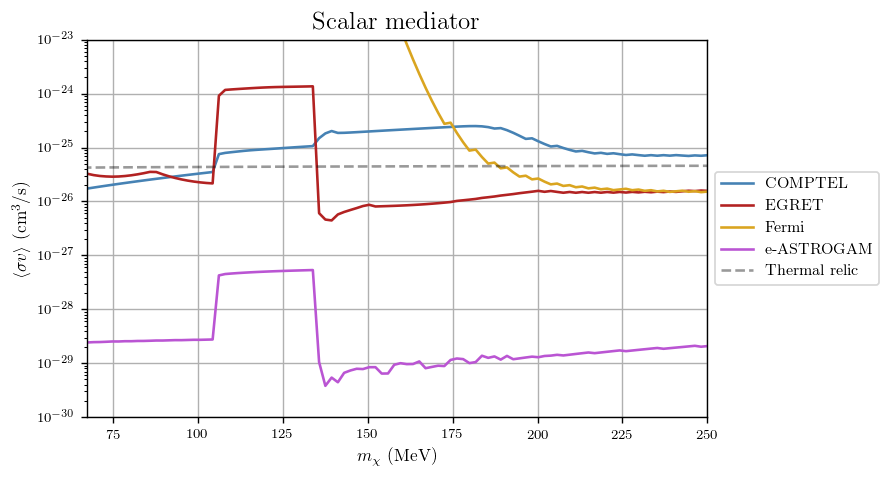

In [11]:
plt.figure(figsize=(8, 4))

plt.plot(sm_mxs, sm_lims_comptel, label="COMPTEL", color=colors[0])
plt.plot(sm_mxs, sm_lims_egret, label="EGRET", color=colors[1])
plt.plot(sm_mxs, sm_lims_fermi, label="Fermi", color=colors[2])
plt.plot(sm_mxs, sm_lims_e_astrogam, label="e-ASTROGAM", color=colors[3])
# plt.plot(sm_mxs, sm_lims_cmb, label="CMB", color="black")
# plt.plot(sm_mxs, sm_lims_cmb_alternate, color="black")
plt.plot(rd_mxs, rd_lims, '--', label="Thermal relic", color="black", alpha=0.4)

plt.xlim(sm_mxs[[0, -1]])
plt.ylim([1e-30,1e-23])
# plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title("Scalar mediator")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig("figures/sm_sigmav_limits.pdf")

In [ ]:
import os
os.system('say "Done computing limits"')

# Vector mediator

## Setup

In [11]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 50
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

In [3]:
vm_lims_comptel = vm.binned_limits(vm_mxs, comptel_diffuse)
vm_lims_egret = vm.binned_limits(vm_mxs, egret_diffuse)
vm_lims_fermi = vm.binned_limits(vm_mxs, fermi_diffuse)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [4]:
vm_lims_e_astrogam = vm.unbinned_limits(vm_mxs, target_params=gc_bg_model_target, bg_model=gc_bg_model)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:150: RuntimeWarning: divide by zero encountered in double_scalars
  return prefactor * n_sigma / (-limit_obj.fun)


In [ ]:
vm_lims_cmb = vm.cmb_limits(vm_mxs)

In [7]:
# np.savetxt("data/vm_lims_comptel.csv",
#            np.array([vm_mxs, vm_lims_comptel]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_egret.csv",
#            np.array([vm_mxs, vm_lims_egret]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_fermi.csv",
#            np.array([vm_mxs, vm_lims_fermi]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [8]:
# np.savetxt("data/vm_lims_e_astrogam.csv",
#            np.array([vm_mxs, vm_lims_e_astrogam]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

In [ ]:
# np.savetxt("data/vm_lims_cmb.csv",
#            np.array([vm_mxs, vm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

## Load previously computed constraints

In [7]:
vm_mxs, vm_lims_egret = np.loadtxt("data/vm_lims_egret.csv", delimiter=",").T
vm_mxs, vm_lims_comptel = np.loadtxt("data/vm_lims_comptel.csv", delimiter=",").T
vm_mxs, vm_lims_fermi = np.loadtxt("data/vm_lims_fermi.csv", delimiter=",").T
vm_mxs, vm_lims_e_astrogam = np.loadtxt("data/vm_lims_e_astrogam.csv", delimiter=",").T
vm_mxs, vm_lims_cmb = np.loadtxt("data/vm_lims_cmb.csv", delimiter=",").T

## Plot results

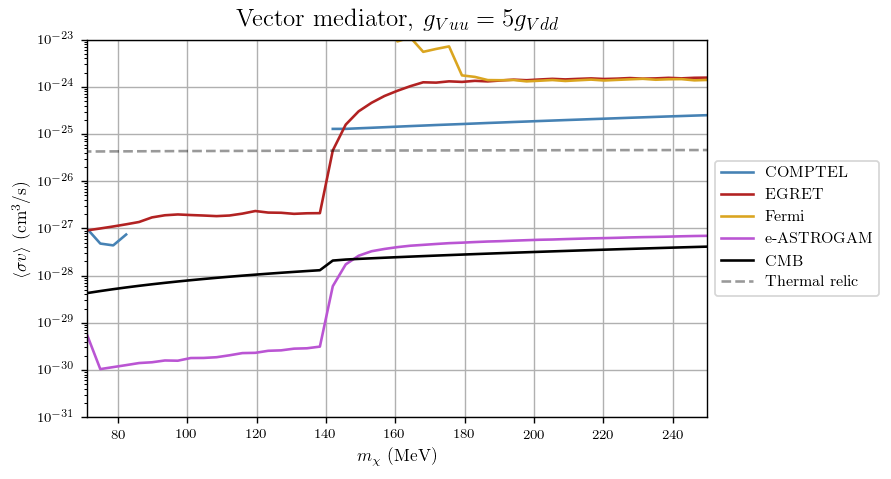

In [14]:
plt.figure(figsize=(8, 4))

plt.plot(vm_mxs, vm_lims_comptel, label="COMPTEL", color=colors[0])
plt.plot(vm_mxs, vm_lims_egret, label="EGRET", color=colors[1])
plt.plot(vm_mxs, vm_lims_fermi, label="Fermi", color=colors[2])
plt.plot(vm_mxs, vm_lims_e_astrogam, label="e-ASTROGAM", color=colors[3])
plt.plot(vm_mxs, vm_lims_cmb, label="CMB", color="black")
plt.plot(rd_mxs, rd_lims, '--', label="Thermal relic", color="black", alpha=0.4)

plt.xlim(vm_mxs[[1, -1]])
plt.ylim([1e-31,1e-23])
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title(r"Vector mediator, $g_{Vuu} = %i g_{Vdd}$" % (vm.gvuu/vm.gvdd))

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("figures/vm_sigmav_limits.pdf")

In [6]:
import os
os.system('say "Done computing limits"')

0

## Look out how constraints vary with couplings

In [39]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = 140., 180., 30
mxs = np.linspace(mx_min, mx_max, n_mxs)

# Couplings to scan over
# gvdds = np.linspace(-0.5, 1.5, 5)
gvdds = np.array([-0.5, 0.9, 1., 2.])

In [44]:
# Compute EGRET limits for the different couplings
# vm_lims_egret_gvdd = []

for gvdd in gvdds[2:]:
    print "gvdd = %f" % gvdd
    vm.gvdd = gvdd
    vm_lims_egret_gvdd.append(vm.binned_limits(mxs, egret_diffuse))

gvdd = 1.000000
gvdd = 2.000000


In [45]:
# Set up the colormap
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.viridis
norm = Normalize(vmin=gvdds[0], vmax=gvdds[-1])
m = cm.ScalarMappable(norm=norm, cmap=cmap)

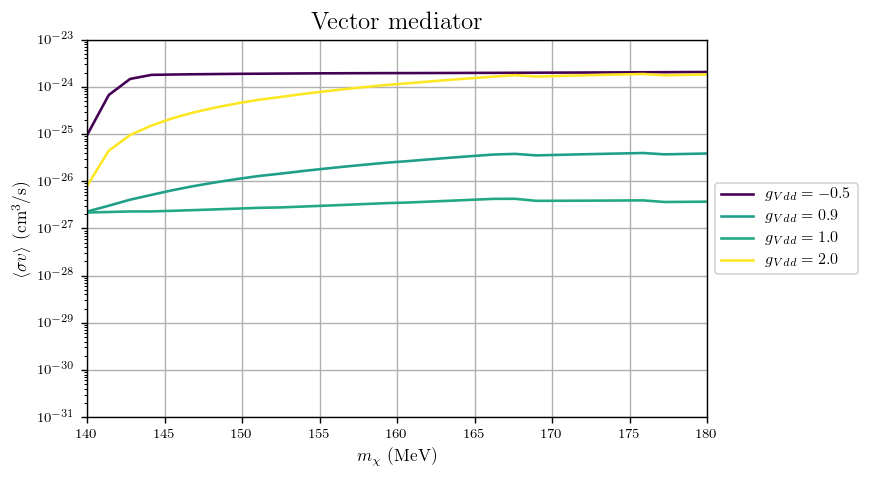

In [48]:
plt.figure(figsize=(8, 4))

for gvdd, lims in zip(gvdds, vm_lims_egret_gvdd):
    plt.plot(mxs, lims, label=r"$g_{Vdd}=%.1f$" % gvdd,
             color=m.to_rgba(gvdd))

# Formatting
plt.xlim(mxs[[0, -1]])
plt.ylim([1e-31,1e-23])
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title("Vector mediator")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Scratch/testing

(1e-10, 1.0)

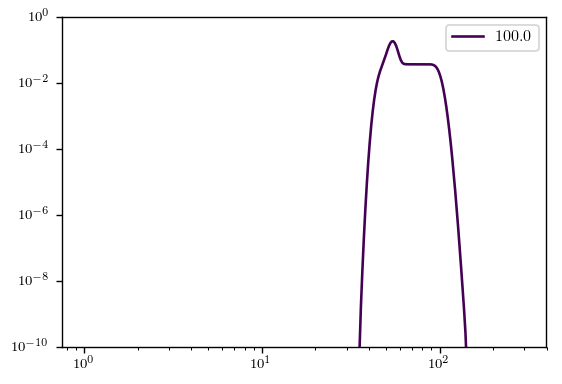

In [23]:
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import energy_res_comptel
import matplotlib.cm as cm
from matplotlib.colors import Normalize

vm = VectorMediator(mx=1., mv=201., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# mx_min, mx_max, n_mxs = 70, 200., 4
# mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)
mxs = np.array([100.])

cmap = cm.viridis
norm = Normalize(vmin=np.log10(mxs[0]), vmax=np.log10(mxs[-1]))

e_gams = np.logspace(0, np.log10(300), 300)

for mx in mxs:
    vm.mx = mx
    e_cm = 2.*vm.mx*(1.+0.5*1e-6)

    dnde_det = get_detected_spectrum(e_gams, vm.spectra(e_gams, e_cm)["total"], *vm.gamma_ray_lines(e_cm), energy_res=energy_res_comptel)
    
    plt.loglog(e_gams, dnde_det(e_gams), color=cmap(norm(np.log10(mx))), label="%.1f" % mx)
    
plt.legend()
plt.ylim(1e-10, 1e0)

In [30]:
for fm in [comptel_diffuse, egret_diffuse, fermi_diffuse]:
    print fm.bins[0][0], fm.bins[-1][-1]

0.7703084693028202 27.618455799248043
27.618455799248043 8626.25729321894
153.2191922762135 94968.96255955588


In [17]:
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum

mx = 200.
vm.mx = mx
e_cm = 2.*vm.mx * (1. + 0.5*1e-6)

e_gams = np.logspace(np.log10(A_eff_e_astrogam.x[0])-1,
                     np.log10(A_eff_e_astrogam.x[-1])+1, 75)
dndes = vm.spectra(e_gams, e_cm)["total"]

dnde_det = get_detected_spectrum(e_gams, dndes, *vm.gamma_ray_lines(e_cm), energy_res=energy_res_e_astrogam)

In [18]:
e_min = max(A_eff_e_astrogam.x[0],
            dnde_det.x[np.where(dnde_det.y)[0][0]])
e_max = min(A_eff_e_astrogam.x[-1],
            dnde_det.x[np.where(dnde_det.y)[0][-1]])
e_dnde_max = dnde_det.x[np.argmax(dnde_det.y)]
print(e_min, e_max, e_dnde_max)

e_a_0 = 10.**(0.5 * (np.log10(e_dnde_max) + np.log10(e_min)))
e_b_0 = 10.**(0.5 * (np.log10(e_max) + np.log10(e_dnde_max)))

(0.3, 3000.0, 0.03615782810612527)


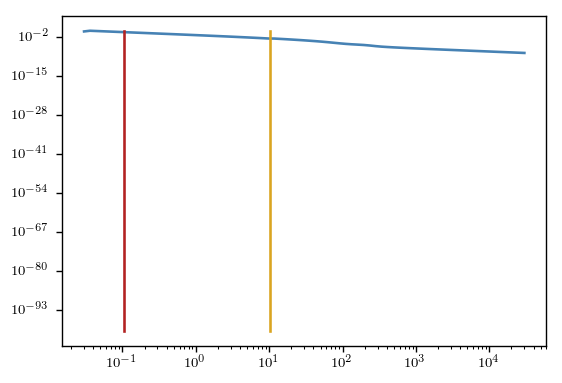

In [19]:
plt.loglog(e_gams, dnde_det(e_gams))
plt.loglog(2*[e_a_0], [1e-100, 1e0])
plt.loglog(2*[e_b_0], [1e-100, 1e0])